<h1 
style='
font-weight: bolder;
text-shadow: 7px 4px 5px #7a90de;
text-align: center;
color: #4563d1;
font-size: 40px;
padding-top: 0px;
padding-bottom: 2px;
'>Detección de Enfermedades Pulmonares </h1> <br/>
<p style='font-size: 16px;'>Crearemos una red neuronal artificial Convolucional que detecte en las radiografías de los pacientes alguna enfermedad pulmonar como COVID-19, Pneumoníal Bacterial, Pneumonía Vírica o ninguna.</p><br/>

dataset: https://github.com/ieee8023/covid-chestxray-dataset & https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 

<h1 
style='
color: green;
'>Análisis Descriptivo Básico</h1>

In [20]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Carga de dataset
import os
import cv2

# Directorio de las imágenes
dataset_path=r'train_test/dataset'
os.listdir(dataset_path)

['0', '1', '2', '3']

In [22]:
# Generador de imágenes con cross-validation y escalado
# ATENCIÓN: crea también imágenes de tensores y no numpy arrays
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale=1./255, validation_split= 0.2)

In [23]:
train_generator = generator.flow_from_directory(batch_size= 40, directory = dataset_path, shuffle= True,
                                                target_size=(256,256), class_mode = "categorical", subset='training')

Found 428 images belonging to 4 classes.


In [24]:
train_generator = generator.flow_from_directory(batch_size= 40, directory = dataset_path, shuffle= True,
                                                target_size=(256,256), class_mode = "categorical", subset='validation')

Found 104 images belonging to 4 classes.


In [25]:
train_images, train_labels = next(train_generator)

In [26]:
train_images.shape

(40, 256, 256, 3)

In [27]:
train_labels.shape

(40, 4)

In [28]:
train_labels[1]

array([0., 0., 0., 1.], dtype=float32)

In [29]:
# Traducción de las etiquetas
labels_names = {0:'COVID-19', 1:'Saludable', 2:'Neumonía Vírica', 3:'Neumonía Pulmonar'}

<h1 
style='
color: green;
'>Visualización del Dataset</h1>

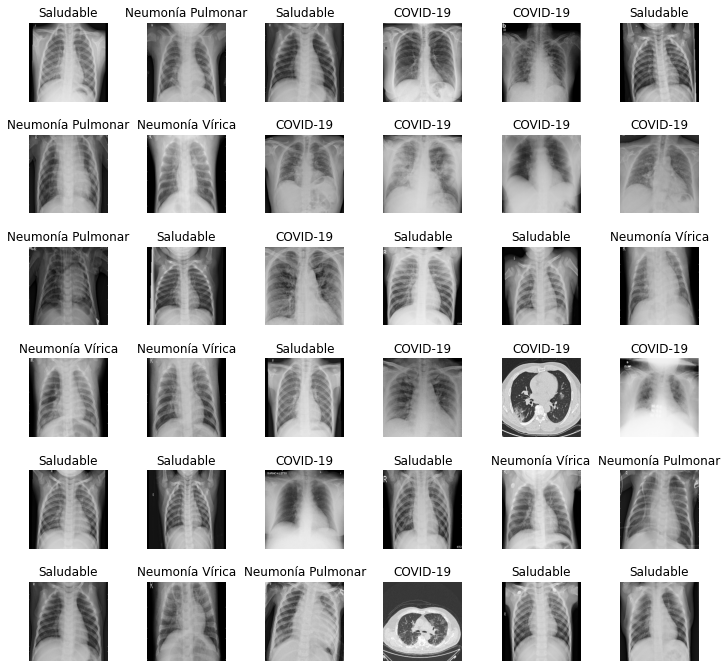

In [30]:
%matplotlib inline
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(wspace = 0.5)

<h1 
style='
color: green;
'>Creación del Modelo</h1>

In [31]:
# Usaremos una red neuronal preentrenada para detectar características llamada ResNet.
# Haremos una transferencia de aprendizaje y crearemos un modelo nuevo.
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

base_model = ResNet50(weights = 'imagenet', include_top=False, input_tensor = Input(shape=(256,256,3)))

In [32]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [33]:
#Congelamos todas las capas menos las ultimas 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

<h1 
style='
color: green;
'>Entrenamiento del Modelo</h1>

In [34]:
# Agregamos la primer capa pooling, una average que saca el promedio de los valores dentro del kernel.
# Luego aplanamos los resultados con una capa Flatten
# Al final una capa Dense con activación relu para anular los resultados menores a 0.
# Agregaremos una capa Dropout para evitar el overfitting, desactivamos el 30% de las neuronas.
# Agregamos mas capas de las anteriores.

from tensorflow.keras.layers import AveragePooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
#head_model = Dense(512, activation='relu')(head_model)
#head_model = Dropout(0.4)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation='softmax')(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

<h3 style='color:#000080;'>¿Por qué esta vez usamos softmax y no sigmoid?</h3>
<h4>Características de una función de activación sigmoidea</h4>
<ul>
    <li>
    Se utiliza para la clasificación binaria en el modelo de regresión logística.
    </li>
    <li>
    La suma de probabilidades de sigmoides no necesita ser 1
    </li>
</ul>
<h4>Características de una función de activación de Softmax</h4>
<ul>
    <li>
    Se utiliza para multiclasificación en el modelo de regresión logística.
    </li>
    <li>
    Las probabilidades de softmax sum serán 1
    </li>
</ul>


In [35]:
from tensorflow.keras import optimizers

# 1e-4 = 1*10^-4 = o .ooo1
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4, decay = 1e-6)
              , metrics=['accuracy'])

In [36]:
# Para evitar el overfitting podemos hacer un "early stopping" para salir del entrenamiento si la pérdida en la validación
# no disminuye despues de ciertos epochs.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_s = EarlyStopping(monitor = 'val_loss', mode='min', verbose= 1, patience=20)

# Guardamos el mejor modelo 
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose = 1, save_best_only=True)

In [37]:
train_generator = generator.flow_from_directory(batch_size = 4, directory = dataset_path, shuffle= True,
                                               target_size = (256,256), class_mode='categorical', subset='training')

val_generator = generator.flow_from_directory(batch_size = 4, directory = dataset_path, shuffle= True,
                                               target_size = (256,256), class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
epochs_hist = model.fit(train_generator, steps_per_epoch=train_generator.n//4, epochs = 50,
                                 validation_data = val_generator, validation_steps = val_generator.n//4,
                                 callbacks = [checkpointer, early_s])

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 1.4372 - accuracy: 0.3294
Epoch 1: val_loss improved from inf to 1.37599, saving model to weights.hdf5
107/107 [==============================] - 117s 1s/step - loss: 1.4372 - accuracy: 0.3294 - val_loss: 1.3760 - val_accuracy: 0.2500
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 1.2669 - accuracy: 0.4042
Epoch 2: val_loss improved from 1.37599 to 1.26077, saving model to weights.hdf5


<h1 
style='
color: green;
'>Evaluación del Modelo</h1>

In [ ]:
epochs_hist.history.keys()

In [ ]:
plt.plot(epochs_hist.history['accuracy'])
plt.plot(epochs_hist.history['loss'])

plt.title('Pérdida y Precisión durante el entrenamiento del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión y Pérdida')
plt.legend(['Precisión(train)', 'Pérdida(train)'])

In [ ]:
plt.plot(epochs_hist.history['val_loss'])

plt.title('Pérdida en Validación Cruzada del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida en Validación')
plt.legend(['Precisión'])

In [ ]:
plt.plot(epochs_hist.history['val_accuracy'])

plt.title('Precisión en Validación Cruzada del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión en Validación')
plt.legend(['Precisión'])

In [ ]:
test_dir = r'train_test/test'
os.listdir(test_dir)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size= 40, directory = test_dir, shuffle= True,
                                                target_size=(256,256), class_mode = "categorical")

In [ ]:
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n//4, verbose=1)

In [ ]:
print('Precisión en la fase de Test: {}'.format(evaluate[1]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_dir))):
    for item in os.listdir(os.path.join(test_dir, str(i))):
        
        # Añadir imágen
        img = cv2.imread(os.path.join(test_dir, str(i), item))
        img = cv2.resize(img,(256,256))
        image.append(img)
        
        # Escalado
        img = img/255
        img = img.reshape(-1,256,256,3)
        
        # Predicción / Añadir predicción
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        
        # Añadir etiqueta real
        original.append(i)
        

In [ ]:
len(original)

In [ ]:
score = accuracy_score(original, prediction)
print(score)

In [ ]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize=(22,22))
axes = axes.ravel()

for i in np.arange(0, W*L):
    axes[i].imshow(image[i])
    axes[i].set_title('Predicción= {}  \nVerdadera = {}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace= 0.5)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot= True, ax = ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Original')
ax.set_title('Matriz de Confusión')

In [ ]:
from keras.models import load_model
best_model = load_model('weights.hdf5')